## import & load

In [1]:
import pandas as pd
import numpy as np
import sys
import requests
import pprint

import datetime
import pytz
import importlib
import matplotlib.pyplot as plt

import datetime, json, math
from google.cloud import bigquery
from numpy_ext import rolling_apply as rolling_apply_ext

In [2]:
import os

if os.path.exists('credential.json'):
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.path.join(os.getcwd(), 'credential.json')

In [3]:
import data.read
importlib.reload(data.read)

<module 'data.read' from '/home/junlim/projects/jitter_recovery/data/read.py'>

In [28]:
#df = data.read.df_okx_20231201_1231.dropna()
df = data.read.df_okx_20240101_0131.dropna()
#df = data.read.df_okx_20240203_0205.dropna()
df_close = df.pivot(index='timestamp', columns='symbol', values='close')
dfi = df.set_index(['timestamp', 'symbol'])
all_symbols = df.symbol.unique()

In [29]:
df.tail(3)

,timestamp,symbol,open,high,low,close,volume
4060708,2024-01-31 04:58:00,NEO-USDT-SWAP,11.6310,11.6320,11.6240,11.6260,310.0000
4060709,2024-01-31 04:58:00,BTC-USD-SWAP,42960.8000,42960.9000,42951.9000,42954.7000,3.8149
4060710,2024-01-31 04:58:00,CFX-USDT-SWAP,0.2263,0.2263,0.2259,0.2261,140070.0000


In [30]:
all_symbols = [s for s in all_symbols if s]

In [31]:
len([s for s in all_symbols if 'USDT' in s])

163

## multiple symbols

In [32]:
import algo.jitter_recovery.calculate
importlib.reload(algo.jitter_recovery.calculate)
import algo.jitter_recovery.research
importlib.reload(algo.jitter_recovery.research)

<module 'algo.jitter_recovery.research' from '/home/junlim/projects/jitter_recovery/algo/jitter_recovery/research.py'>

In [33]:
feature_param = algo.jitter_recovery.calculate.JitterRecoveryFeatureParam(40)
trading_param = algo.jitter_recovery.calculate.JitterRecoveryTradingParam(
    feature_param, 
    0.20, -0.04, 0.02, is_long_term=False)

In [34]:
dfst_feature_approximate, dfst_feature, dfst_trading = algo.jitter_recovery.research.get_dfsts(df, trading_param)

0 symbol: TURBO-USDT-SWAP: 13 (approx)
1 symbol: LOOKS-USDT-SWAP: 4 (approx)
2 symbol: IOST-USDT-SWAP: 0 (approx)
3 symbol: TRX-USDT-SWAP: 0 (approx)
4 symbol: PEPE-USDT-SWAP: 0 (approx)
5 symbol: BLUR-USDT-SWAP: 0 (approx)
6 symbol: NFT-USDT-SWAP: 0 (approx)
7 symbol: TIA-USDT-SWAP: 3 (approx)
8 symbol: STX-USDT-SWAP: 0 (approx)
9 symbol: ALGO-USDT-SWAP: 0 (approx)
10 symbol: ETH-USDT-SWAP: 0 (approx)
11 symbol: AGIX-USDT-SWAP: 0 (approx)
12 symbol: FET-USDT-SWAP: 0 (approx)
13 symbol: THETA-USDT-SWAP: 0 (approx)
14 symbol: KSM-USDT-SWAP: 0 (approx)
15 symbol: STORJ-USDT-SWAP: 0 (approx)
16 symbol: PEOPLE-USDT-SWAP: 50 (approx)
17 symbol: WOO-USDT-SWAP: 0 (approx)
18 symbol: USTC-USDT-SWAP: 0 (approx)
19 symbol: MATIC-USDT-SWAP: 0 (approx)
20 symbol: TON-USDT-SWAP: 0 (approx)
21 symbol: AXS-USDT-SWAP: 0 (approx)
22 symbol: GMX-USDT-SWAP: 3 (approx)
23 symbol: ONT-USDT-SWAP: 0 (approx)
24 symbol: HBAR-USDT-SWAP: 0 (approx)
25 symbol: GMT-USDT-SWAP: 0 (approx)
26 symbol: CSPR-USDT-SWAP:

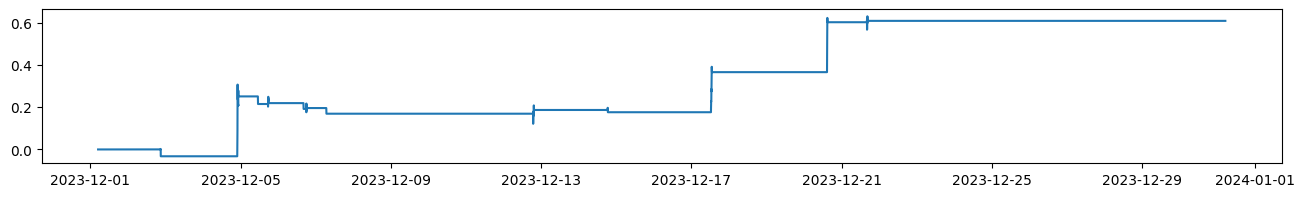

In [27]:
algo.jitter_recovery.research.investigate_trading(dfst_feature_approximate, dfst_trading)

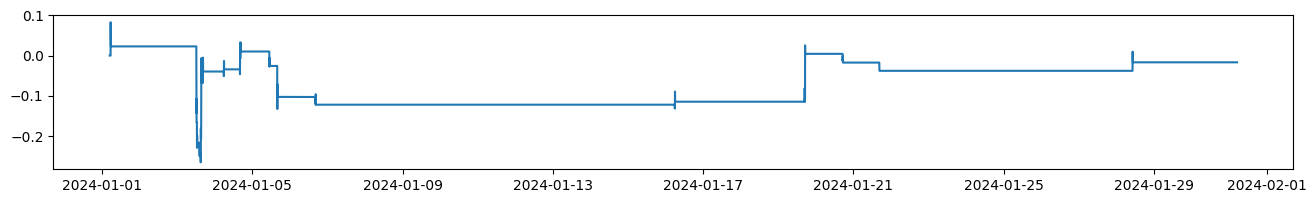

In [35]:
algo.jitter_recovery.research.investigate_trading(dfst_feature_approximate, dfst_trading)

<Axes: xlabel='timestamp'>

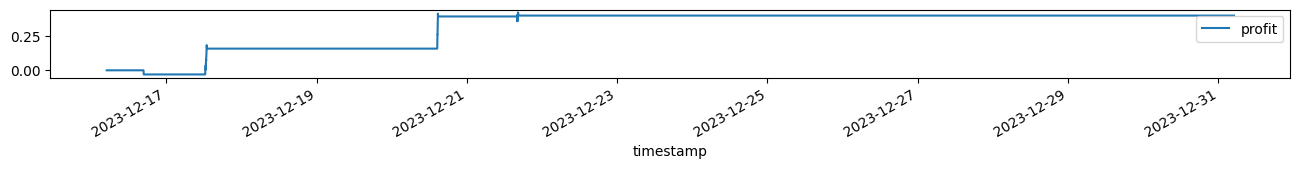

In [28]:
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(16,1))

<Axes: xlabel='timestamp'>

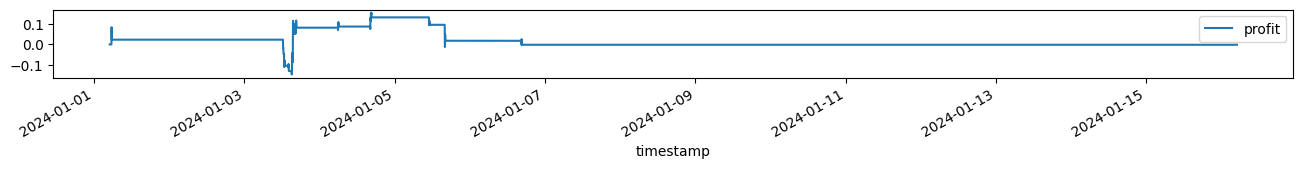

In [42]:
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(16,1))

<Axes: xlabel='timestamp'>

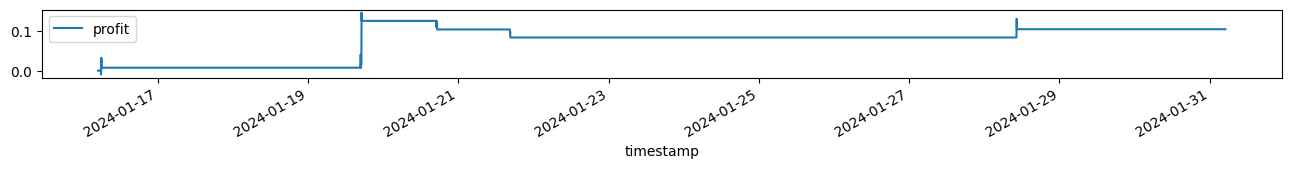

In [175]:
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(16,1))

In [220]:
dfst_trading[['profit']].groupby('symbol').sum().sort_values('profit')

,profit
symbol,
DMAIL-USDT-SWAP,-0.003662
1INCH-USD-SWAP,0.000000
MKR-USDT-SWAP,0.000000
MOVR-USDT-SWAP,0.000000
NEAR-USDT-SWAP,0.000000
...,...
ETHW-USDT-SWAP,0.000000
FET-USDT-SWAP,0.000000
FIL-USDT-SWAP,0.000000


In [1]:
#dfst_feature.xs('FITFI-USDT-SWAP').loc['2023-12-07 16:38:00']

In [ ]:
dfst_trading[(dfst_trading.ch_max > 0.15) & (dfst_trading.ch_since_max < -0.01)]

In [ ]:
dfst_trading[(dfst_trading.ch_max > 0.15) & (dfst_trading.ch_since_max < 0)].loc[symbol_with_jumps[0]]

In [221]:
for _, row in dfst_trading[(dfst_trading.position_changed != 0)].dropna().reset_index().sort_values('timestamp').iterrows():
    print(f'{row["timestamp"]}, {row["symbol"]}, {row["value"]}, position_changed: {row["position_changed"]}')

2024-02-03 18:13:00, GAL-USDT-SWAP, 1.905, position_changed: 1.0
2024-02-03 19:18:00, GAL-USDT-SWAP, 1.852, position_changed: -1.0
2024-02-04 00:19:00, FITFI-USDT-SWAP, 0.006064, position_changed: 1.0
2024-02-04 00:31:00, FITFI-USDT-SWAP, 0.005904, position_changed: -1.0
2024-02-04 20:20:00, DMAIL-USDT-SWAP, 0.4964, position_changed: 1.0
2024-02-04 20:23:00, DMAIL-USDT-SWAP, 0.5023, position_changed: -1.0
2024-02-04 20:24:00, DMAIL-USDT-SWAP, 0.4965, position_changed: 1.0
2024-02-04 20:55:00, DMAIL-USDT-SWAP, 0.4923, position_changed: -1.0


## single symobl

In [373]:
import algo.jitter_recovery.calculate
importlib.reload(algo.jitter_recovery.calculate)
import algo.jitter_recovery.research
importlib.reload(algo.jitter_recovery.research)

<module 'algo.jitter_recovery.research' from '/home/junlim/projects/jitter_recovery/algo/jitter_recovery/research.py'>

In [374]:
symbol_investigate = 'GAL-USDT-SWAP'
dfs = dfi.xs(symbol_investigate, level=1)

In [375]:
jitter_recovery_trading_param = algo.jitter_recovery.calculate.JitterRecoveryTradingParam(
    algo.jitter_recovery.calculate.JitterRecoveryFeatureParam(40), 
    0.20, -0.04, 0.02, is_long_term=False)

in_position: 1, value_at_enter: 1.905, lowest_since_enter: 1.905, timedelta_since_position_enter: 0, v_ch_max_is_to_when_enter: 1.971, v_ch_min_is_to_when_enter: 1.905, v_ch_max_is_from_when_enter: 1.788, v_ch_min_is_from_when_enter: 1.971, ch_from_enter: 0, ch_from_lowest_since_enter: 0
trading_param:
jitter_recovery_feature_param: <numba.experimental.jitclass.boxing.JitterRecoveryFeatureParam object at 0x7fab555993c0>, jump_threshold: 0.05, drop_from_jump_threshold: -0.03, exit_jumpt_threshold: 0.01, is_long_term: False
features:
0.10234899328859064, -0.03348554033485543, 6.0, 0.006422815104427623


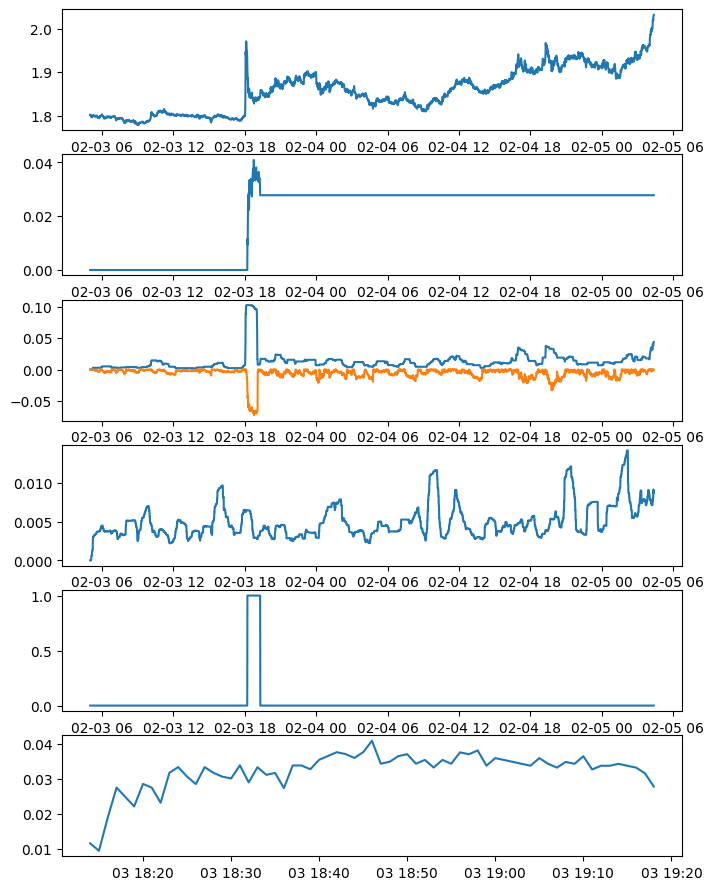

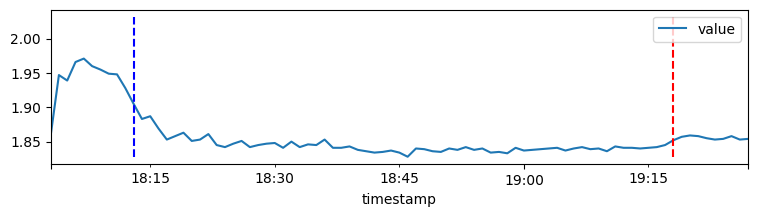

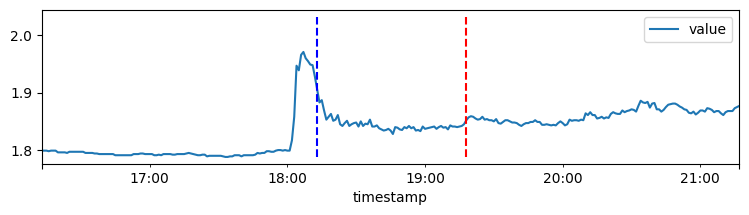

In [377]:
df_feature, df_trading = algo.jitter_recovery.research.investigate_symbol(df, df_collective_feature_approxiamate, symbol_investigate, jitter_recovery_trading_param, figsize=(8, 11))

In [378]:
df_trading[
    (df_trading.index >=  '2024-01-03 12:14:00') &
    (df_trading.index <=  '2024-01-03 12:18:00')
]

,avg_v_before_max_ch,avg_v_before_min_ch,ch,ch_max,ch_min,ch_since_max,ch_since_min,distance_max_ch,distance_min_ch,v_ch_max_is_from,...,timedelta_since_position_enter,v_ch_max_is_to_when_enter,v_ch_min_is_to_when_enter,v_ch_max_is_from_when_enter,v_ch_min_is_from_when_enter,ch_from_enter,ch_from_lowest_since_enter,position_changed,profit_raw,profit
timestamp,,,,,,,,,,,,,,,,,,,,,


In [146]:
df_trading[(df_trading.position_changed != 0)][['value', 'in_position', 'position_changed', 'profit_raw', 'profit']].dropna()

,value,in_position,position_changed,profit_raw,profit
timestamp,,,,,
2024-01-03 12:27:00,1.7395,1,1.0,0.000,0.000000
2024-01-03 12:29:00,1.8060,0,-1.0,-0.016,-0.008939


In [147]:
for _, row in dfst_trading[(dfst_trading.position_changed != 0)].dropna().reset_index().sort_values('timestamp').iterrows():
    if row['symbol'] != symbol_investigate: continue
    print(f'{row["timestamp"]}, {row["symbol"]}, {row["value"]}, position_changed: {row["position_changed"]}')

2024-01-03 12:27:00, ARB-USDT-SWAP, 1.7395, position_changed: 1.0
2024-01-03 12:28:00, ARB-USDT-SWAP, 1.79, position_changed: -1.0
